# 사전설정

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np

## 종목 설정

In [13]:
# 1. 설정
risk_on_tickers = {
    'KODEX 200': '069500.KS',
    'KODEX 코스닥150': '229200.KS',
}
risk_off_ticker = {'KOSEF 국고채10년': '148070.KS'}
all_tickers = {**risk_on_tickers, **risk_off_ticker}

# 데이터 로드

In [14]:
# 모멘텀 계산(최대 12개월)을 위해 2023년 데이터부터 다운로드
start_date = '2023-01-01'
end_date = '2024-12-31'
backtest_start_date = '2024-01-01'
initial_capital = 100000000 # 초기 자본금 1억원

In [15]:
# 2. 데이터 다운로드
try:
    # 데이터 다운로드
    raw_data = yf.download(list(all_tickers.values()), start=start_date, end=end_date, progress=False, auto_adjust=False)
    
    # Close 가격 추출 (Adj Close가 없으므로 Close 사용)
    data = raw_data['Close'].copy()
    
    # 컬럼명을 티커명으로 변경
    data.columns = all_tickers.keys()
    
    if data.isnull().values.any():
        print("데이터에 누락된 값이 있어 채워넣습니다.")
        data.fillna(method='ffill', inplace=True)
    
    print("데이터 다운로드 성공!")
    print(f"데이터 형태: {data.shape}")
    print(f"\n최근 5행:\n{data.tail()}")
    
except Exception as e:
    import traceback
    print(f"데이터 다운로드 중 오류 발생: {e}")
    traceback.print_exc()

데이터 다운로드 성공!
데이터 형태: (470, 3)

최근 5행:
            KODEX 200  KODEX 코스닥150  KOSEF 국고채10년
Date                                             
2024-12-23    32400.0      117760.0       11155.0
2024-12-24    32425.0      117320.0       11225.0
2024-12-26    32235.0      117045.0       11180.0
2024-12-27    32145.0      113095.0       11055.0
2024-12-30    32060.0      113310.0       11275.0


# 백테스트 수행

## 전략 검증 포인트
- ✅ **투자 유니버스**: 위험자산 2종 (KODEX 200, KODEX 코스닥150) + 안전자산 1종 (KOSEF 국고채10년)
- ✅ **상대 모멘텀**: 위험자산 중 6개월 수익률 1위 선정
- ✅ **절대 모멘텀**: 선정 자산의 12개월 수익률이 0 이상인지 확인
- ✅ **투자 방식**: 선정된 단일 자산에 100% 집중 투자 (12개월 수익률 > 0이면 위험자산, ≤ 0이면 안전자산)
- ✅ **리밸런싱**: 매월 마지막 거래일 장 마감 후 결정
- ✅ **적용 시점**: 리밸런싱 다음 영업일부터 새로운 자산 보유

In [16]:
# 3. 백테스트 시뮬레이션
backtest_data = data.loc[backtest_start_date:]
rebalance_dates = backtest_data.resample('M').last().index

portfolio_history = pd.Series(index=backtest_data.index, dtype=float)

# 월별 리밸런싱 루프
for i in range(len(rebalance_dates)):
    rebal_date = rebalance_dates[i]
    
    # --- 매매 신호 결정 (장 마감 후) ---
    # 6개월, 12개월 전 날짜 계산
    date_6m_ago = rebal_date - pd.DateOffset(months=6)
    date_12m_ago = rebal_date - pd.DateOffset(months=12)

    # 과거 가격 데이터 추출 (휴무일 고려 - 가장 가까운 이전 거래일 사용)
    hist_data_6m = data.loc[:date_6m_ago]
    hist_data_12m = data.loc[:date_12m_ago]
    hist_data_current = data.loc[:rebal_date]
    
    if len(hist_data_6m) == 0 or len(hist_data_12m) == 0 or len(hist_data_current) == 0:
        print(f"\n[{rebal_date.strftime('%Y-%m-%d')}] ⚠ 과거 데이터 부족으로 건너뜀")
        continue
    
    price_6m_ago = hist_data_6m.iloc[-1]
    price_12m_ago = hist_data_12m.iloc[-1]
    price_current = hist_data_current.iloc[-1]
    
    # 1. 상대 모멘텀: 위험자산군 내 6개월 수익률 비교
    ret_6m = (price_current[risk_on_tickers.keys()] / price_6m_ago[risk_on_tickers.keys()]) - 1
    relative_winner = ret_6m.idxmax()
    
    # 2. 절대 모멘텀: 상대모멘텀 승자의 12개월 수익률 확인
    ret_12m_winner = (price_current[relative_winner] / price_12m_ago[relative_winner]) - 1
    
    print(f"\n[{rebal_date.strftime('%Y-%m-%d')}] 리밸런싱 (장 마감 후)")
    print(f"6개월 모멘텀: {dict((k, f'{v*100:.2f}%') for k, v in ret_6m.items())}")
    print(f"상대 모멘텀 1위: {relative_winner} (6M 수익률: {ret_6m[relative_winner]*100:.2f}%)")
    print(f"절대 모멘텀: {relative_winner} 12개월 수익률 = {ret_12m_winner*100:.2f}%")
    
    # 최종 투자 대상 결정
    if ret_12m_winner > 0:
        invest_asset = relative_winner
        print(f"✅ 최종 선택: {invest_asset} (위험자산 - 12M 수익률 > 0)")
    else:
        invest_asset = list(risk_off_ticker.keys())[0]
        print(f"🛡️ 최종 선택: {invest_asset} (안전자산 - 12M 수익률 ≤ 0)")

    # --- 포트폴리오 가치 계산 (다음 영업일부터 적용) ---
    start_period = rebal_date + pd.Timedelta(days=1)
    
    if i < len(rebalance_dates) - 1:
        end_period = rebalance_dates[i+1]
    else:
        end_period = backtest_data.index[-1]
    
    # 실제 거래일만 필터링
    period_data = backtest_data.loc[start_period:end_period, invest_asset]
    
    if len(period_data) == 0:
        print(f"  ⚠ 적용 기간 데이터 없음")
        continue
    
    # 이전 기간의 포트폴리오 가치 사용
    if i == 0:
        temp_value = initial_capital
    else:
        # 가장 최근 포트폴리오 가치 찾기
        available_dates = portfolio_history.dropna().index
        if len(available_dates) > 0:
            last_date = available_dates[-1]
            temp_value = portfolio_history.loc[last_date]
        else:
            temp_value = initial_capital
    
    print(f"  → 적용 기간: {period_data.index[0].strftime('%Y-%m-%d')} ~ {period_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"  → 리밸런싱 기준 평가액: {temp_value:,.0f}원")
    
    # 선택된 자산에 100% 투자
    asset_shares = temp_value / period_data.iloc[0]
    
    # 일별 포트폴리오 가치 계산
    portfolio_daily_value = period_data * asset_shares
    
    # 포트폴리오 히스토리에 저장
    portfolio_history.loc[period_data.index] = portfolio_daily_value
    
    print(f"  → 기간 종료 평가액: {portfolio_daily_value.iloc[-1]:,.0f}원")
    print(f"  → 기간 수익률: {(portfolio_daily_value.iloc[-1]/temp_value - 1)*100:+.2f}%")


[2024-01-31] 리밸런싱 (장 마감 후)
6개월 모멘텀: {'KODEX 200': '-1.89%', 'KODEX 코스닥150': '1.55%'}
상대 모멘텀 1위: KODEX 코스닥150 (6M 수익률: 1.55%)
절대 모멘텀: KODEX 코스닥150 12개월 수익률 = 0.19%
✅ 최종 선택: KODEX 코스닥150 (위험자산 - 12M 수익률 > 0)
  → 적용 기간: 2024-02-01 ~ 2024-02-29
  → 리밸런싱 기준 평가액: 100,000,000원
  → 기간 종료 평가액: 99,183,673원
  → 기간 수익률: -0.82%

[2024-02-29] 리밸런싱 (장 마감 후)
6개월 모멘텀: {'KODEX 200': '7.10%', 'KODEX 코스닥150': '1.17%'}
상대 모멘텀 1위: KODEX 200 (6M 수익률: 7.10%)
절대 모멘텀: KODEX 200 12개월 수익률 = 12.32%
✅ 최종 선택: KODEX 200 (위험자산 - 12M 수익률 > 0)
  → 적용 기간: 2024-03-04 ~ 2024-03-29
  → 리밸런싱 기준 평가액: 99,183,673원
  → 기간 종료 평가액: 103,549,392원
  → 기간 수익률: +4.40%

[2024-03-31] 리밸런싱 (장 마감 후)
6개월 모멘텀: {'KODEX 200': '15.44%', 'KODEX 코스닥150': '3.24%'}
상대 모멘텀 1위: KODEX 200 (6M 수익률: 15.44%)
절대 모멘텀: KODEX 200 12개월 수익률 = 16.09%
✅ 최종 선택: KODEX 200 (위험자산 - 12M 수익률 > 0)
  → 적용 기간: 2024-04-01 ~ 2024-04-30
  → 리밸런싱 기준 평가액: 103,549,392원
  → 기간 종료 평가액: 99,936,411원
  → 기간 수익률: -3.49%

[2024-04-30] 리밸런싱 (장 마감 후)
6개월 모멘텀: {'KODEX 200': '18.07%', '

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25536\2380071153.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = backtest_data.resample('M').last().index


# 성과분석

In [17]:
# 4. 성과 분석
portfolio_df = portfolio_history.dropna().to_frame('Portfolio')
portfolio_df['Daily_Return'] = portfolio_df['Portfolio'].pct_change()

final_value = portfolio_df['Portfolio'].iloc[-1]
cagr = ((final_value / initial_capital) ** (365.0 / len(portfolio_df))) - 1

rolling_max = portfolio_df['Portfolio'].cummax()
daily_drawdown = portfolio_df['Portfolio'] / rolling_max - 1.0
mdd = daily_drawdown.min()

sharpe_ratio = portfolio_df['Daily_Return'].mean() / portfolio_df['Daily_Return'].std() * np.sqrt(252)

print(f"초기 자산: {initial_capital:,.0f} 원")
print(f"최종 자산: {final_value:,.0f} 원")
print(f"CAGR (연율화 수익률): {cagr:.2%}")
print(f"MDD (최대 낙폭): {mdd:.2%}")
print(f"Sharpe Ratio (샤프 지수): {sharpe_ratio:.2f}\n")


초기 자산: 100,000,000 원
최종 자산: 94,453,325 원
CAGR (연율화 수익률): -9.07%
MDD (최대 낙폭): -16.87%
Sharpe Ratio (샤프 지수): -0.30



# 성과 시각화

In [18]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 포트폴리오 가치 추이

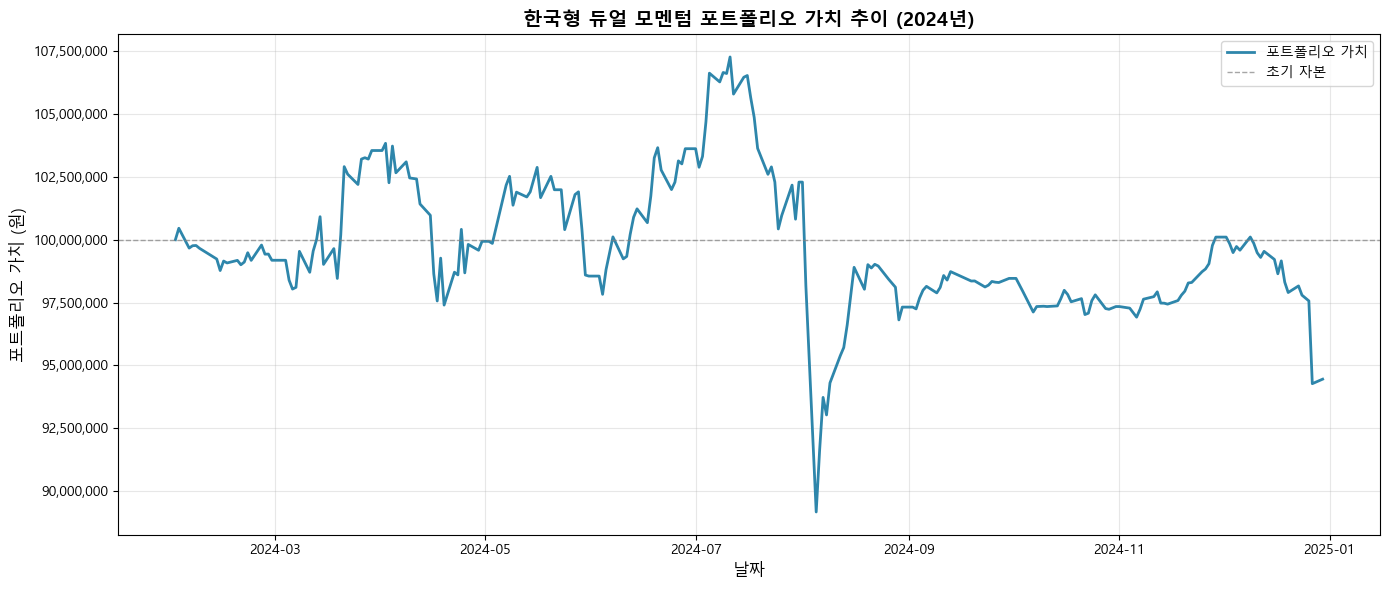

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(portfolio_df.index, portfolio_df['Portfolio'], linewidth=2, color='#2E86AB', label='포트폴리오 가치')
ax.axhline(y=initial_capital, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='초기 자본')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('포트폴리오 가치 (원)', fontsize=12)
ax.set_title('한국형 듀얼 모멘텀 포트폴리오 가치 추이 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

## 2. 누적 수익률 추이

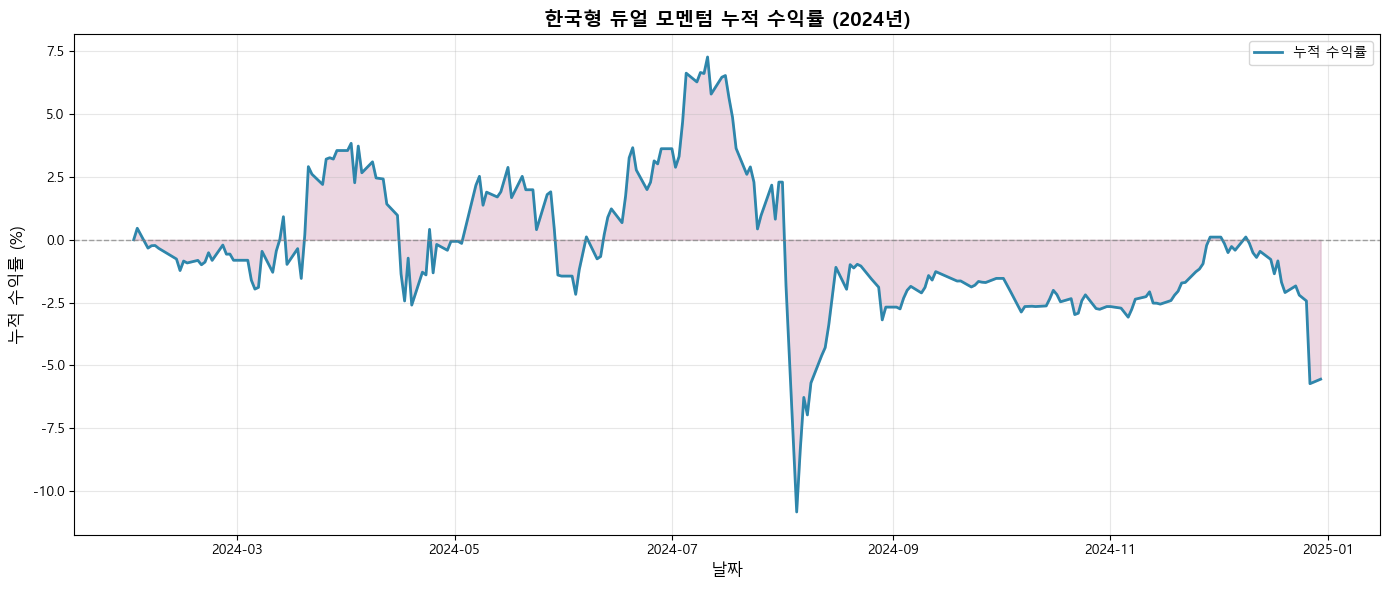

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

cumulative_return = (portfolio_df['Portfolio'] / initial_capital - 1) * 100

ax.plot(portfolio_df.index, cumulative_return, linewidth=2, color='#2E86AB', label='누적 수익률')
ax.fill_between(portfolio_df.index, cumulative_return, 0, alpha=0.2, color='#A23B72')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('누적 수익률 (%)', fontsize=12)
ax.set_title('한국형 듀얼 모멘텀 누적 수익률 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 낙폭(Drawdown) 분석

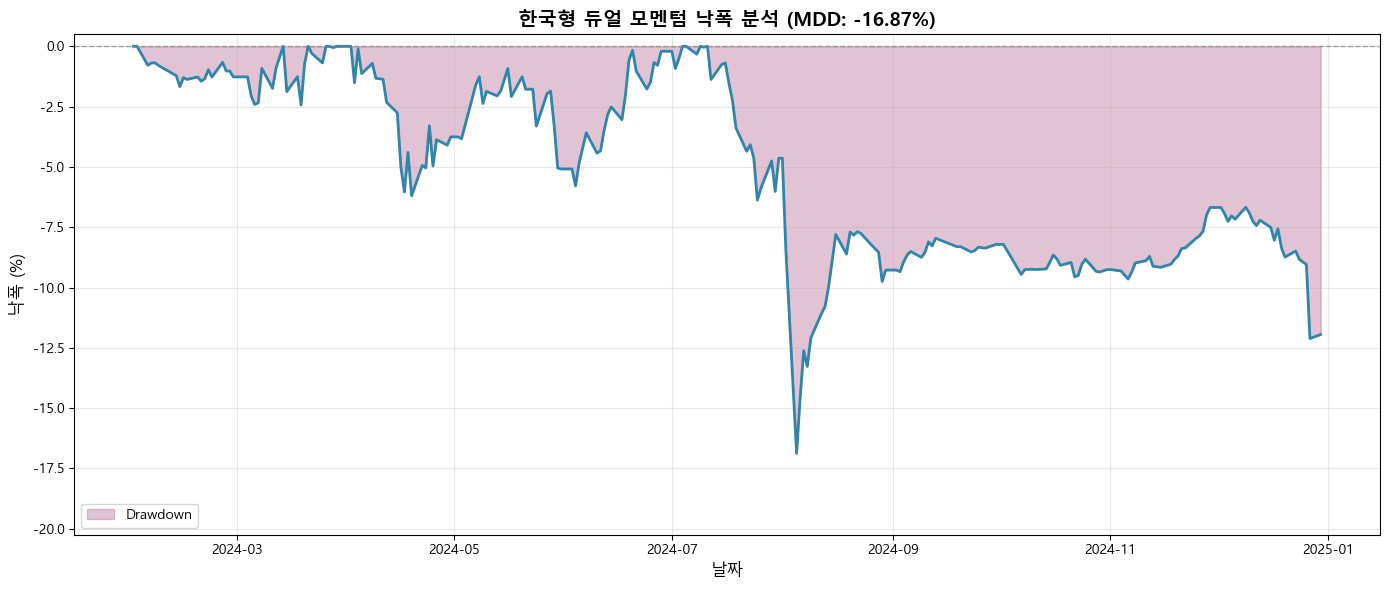

In [21]:
fig, ax = plt.subplots(figsize=(14, 6))

drawdown_pct = daily_drawdown * 100

ax.fill_between(portfolio_df.index, drawdown_pct, 0, alpha=0.3, color='#A23B72', label='Drawdown')
ax.plot(portfolio_df.index, drawdown_pct, linewidth=2, color='#2E86AB')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

y_min = min(drawdown_pct.min() * 1.2, -1)
ax.set_ylim(y_min, 0.5)

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('낙폭 (%)', fontsize=12)
ax.set_title(f'한국형 듀얼 모멘텀 낙폭 분석 (MDD: {mdd:.2%})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 일별 수익률 분포

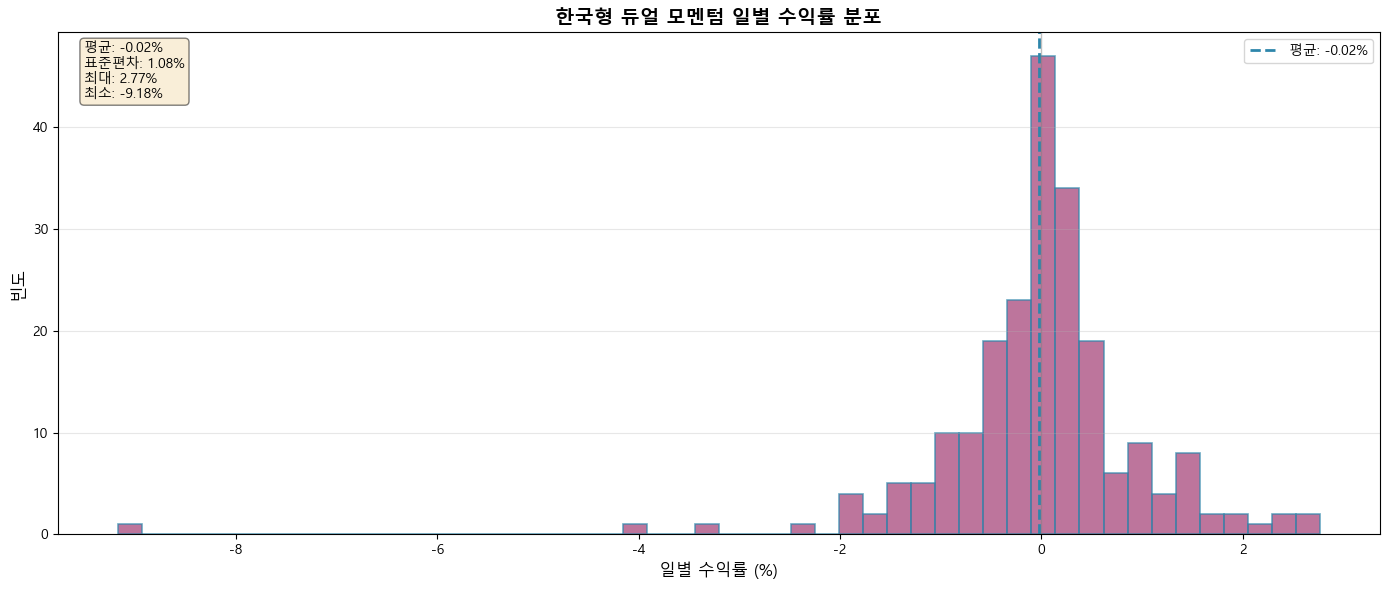

In [22]:
fig, ax = plt.subplots(figsize=(14, 6))

daily_returns_pct = portfolio_df['Daily_Return'].dropna() * 100

ax.hist(daily_returns_pct, bins=50, alpha=0.7, color='#A23B72', edgecolor='#2E86AB', linewidth=1.2)
ax.axvline(x=daily_returns_pct.mean(), color='#2E86AB', linestyle='--', linewidth=2, label=f'평균: {daily_returns_pct.mean():.2f}%')
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

ax.set_xlabel('일별 수익률 (%)', fontsize=12)
ax.set_ylabel('빈도', fontsize=12)
ax.set_title('한국형 듀얼 모멘텀 일별 수익률 분포', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 통계량 표시
textstr = f'평균: {daily_returns_pct.mean():.2f}%\n표준편차: {daily_returns_pct.std():.2f}%\n최대: {daily_returns_pct.max():.2f}%\n최소: {daily_returns_pct.min():.2f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## 5. 월별 수익률

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25536\1837516961.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100


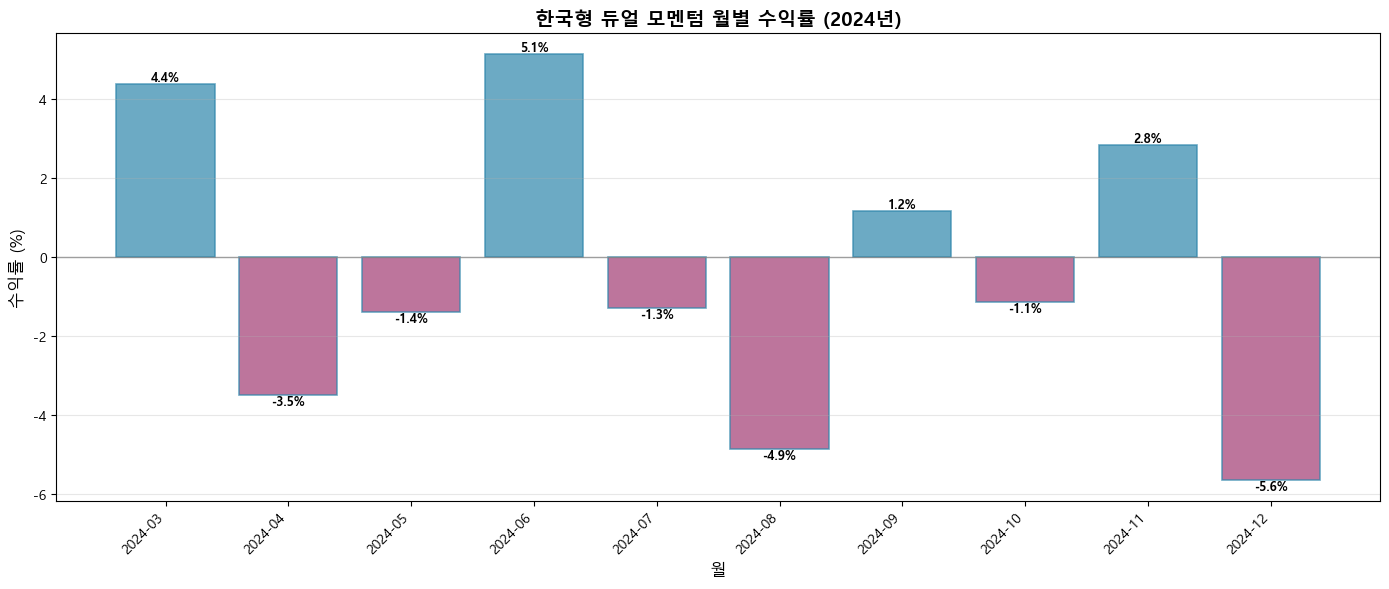

In [23]:
monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#2E86AB' if x >= 0 else '#A23B72' for x in monthly_returns]
bars = ax.bar(range(len(monthly_returns)), monthly_returns, color=colors, alpha=0.7, edgecolor='#2E86AB', linewidth=1.2)

ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.7)
ax.set_xlabel('월', fontsize=12)
ax.set_ylabel('수익률 (%)', fontsize=12)
ax.set_title('한국형 듀얼 모멘텀 월별 수익률 (2024년)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(monthly_returns)))
ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly_returns.index], rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시
for i, (bar, value) in enumerate(zip(bars, monthly_returns)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()